### Importing the necessary packages

In [1]:
import pandas as pd
import sys, os
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

In [2]:
sys.path.append(os.path.abspath('../scripts'))

In [3]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import EDA_and_TSA as eda
import logging
from datetime import datetime
from random_forest_model import build_random_forest_model, evaluate_random_forest_model
from lstm_model import build_lstm_model, scale_lstm_data, reshape_lstm_data, evaluate_lstm_model
from preprocessor import extract_date_features, difference_series,missing_values_table, create_supervised_data, difference_data, check_stationarity, handle_missing_values_zero
from post_prediction_analysis import plot_feature_importance, estimate_confidence_interval, visualize_predictions
from model_serialization_script import serialize_model, load_model
from acf_pacf_script import plot_acf_pacf
from model_comparison_script import evaluate_model_performance, compare_models

### Step 1: Load the data

In [4]:
df = eda.load_data(r'C:\Users\Blen\OneDrive\Desktop\10Academy\SalesDataAnalytics\Data\train_store.csv')

INFO:root:Data loaded successfully.


In [5]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

### Step 2: Preprocess the data

#### 2.1 Extract new data features

In [6]:
df = extract_date_features(df)

INFO:root:Extracting Date Features from the dataset....
INFO:root:Feature extraction completed


In [10]:
missing_values_table(df)

INFO:root:Displaying Missing Value Percentages for Each Column....


The dataframe has 34columns.
There are 0 columns that have missing values.



,Missing Values,% of Total Values,DType


In [8]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,is_StoreType_b,is_StoreType_c,is_StoreType_d,"is_PromoInteval_Feb,May,Aug,Nov","is_PromoInteval_Jan,Apr,Jul,Oct","is_PromoInteval_Mar,Jun,Sept,Dec",is_PromoInteval_Unknown,MonthPhase_Beginning,MonthPhase_Mid,MonthPhase_End
0,1,4,2015-07-31,5263,555,1,1,1,1270.0,9.0,...,False,True,False,False,False,False,True,False,False,True
1,2,4,2015-07-31,6064,625,1,1,1,570.0,11.0,...,False,False,False,False,True,False,False,False,False,True
2,3,4,2015-07-31,8314,821,1,1,1,14130.0,12.0,...,False,False,False,False,True,False,False,False,False,True
3,4,4,2015-07-31,13995,1498,1,1,1,620.0,9.0,...,False,True,False,False,False,False,True,False,False,True
4,5,4,2015-07-31,4822,559,1,1,1,29910.0,4.0,...,False,False,False,False,False,False,True,False,False,True


In [7]:
column = ['IsStateHoliday']
df = handle_missing_values_zero(df, column)

INFO:root:Replacing missing values with 0....


#### 2.2: Differencing for stationarity

In [9]:
df = difference_data(df, 'Sales')
stationary = check_stationarity(df['Sales_diff'])

ADF Statistic: -132.889728
p-value: 0.000000


In [10]:
missing_values_table(df)

INFO:root:Displaying Missing Value Percentages for Each Column....


The dataframe has 35columns.
There are 1 columns that have missing values.



,Missing Values,% of Total Values,DType
Sales_diff,1,0.0,float64


### Step 3: ACF/PACF Plot to analyze stationarity

INFO:root:Plotting ACF and PACF.


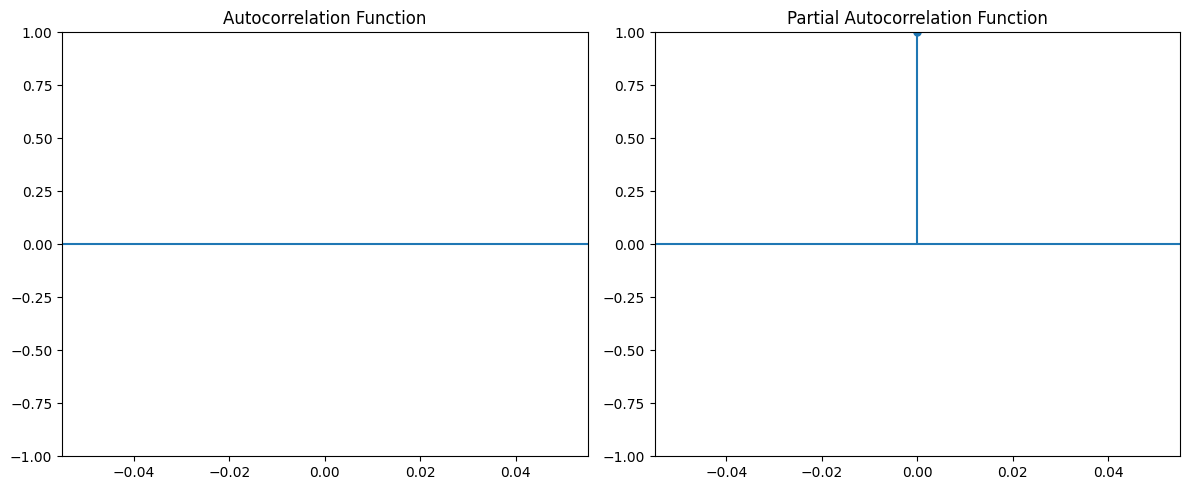

INFO:root:ACF and PACF plotted.


In [11]:
plot_acf_pacf(df['Sales_diff'], lags=50)

### Step 4: Train-test split (recent data for test set)

In [12]:
# Prepare features and labels
X = df.drop(columns=['Date','Sales', 'Sales_diff'])
y = df['Sales']

In [13]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

###  Step 5: Build and Train Random Forest Model

In [14]:
rf_model = build_random_forest_model(X_train, y_train)
rf_rmse, rf_predictions = evaluate_random_forest_model(rf_model, X_test, y_test)
serialize_model(rf_model, 'random_forest_model.pkl')

INFO:root:Serializing random_forest_model.pkl and saving as random_forest_model.pkl-2024-09-25-21-42-41.pkl.
INFO:root:Model random_forest_model.pkl saved successfully.


'random_forest_model.pkl-2024-09-25-21-42-41.pkl'

In [17]:
print(rf_rmse)
print(rf_predictions)

1297.202171031052
[9059.3647305  6268.23426389 9059.3647305  ... 9084.65834127 7634.43773978
 9084.65834127]


### # Step 6: Feature Importance

INFO:root:Plotting feature importance.


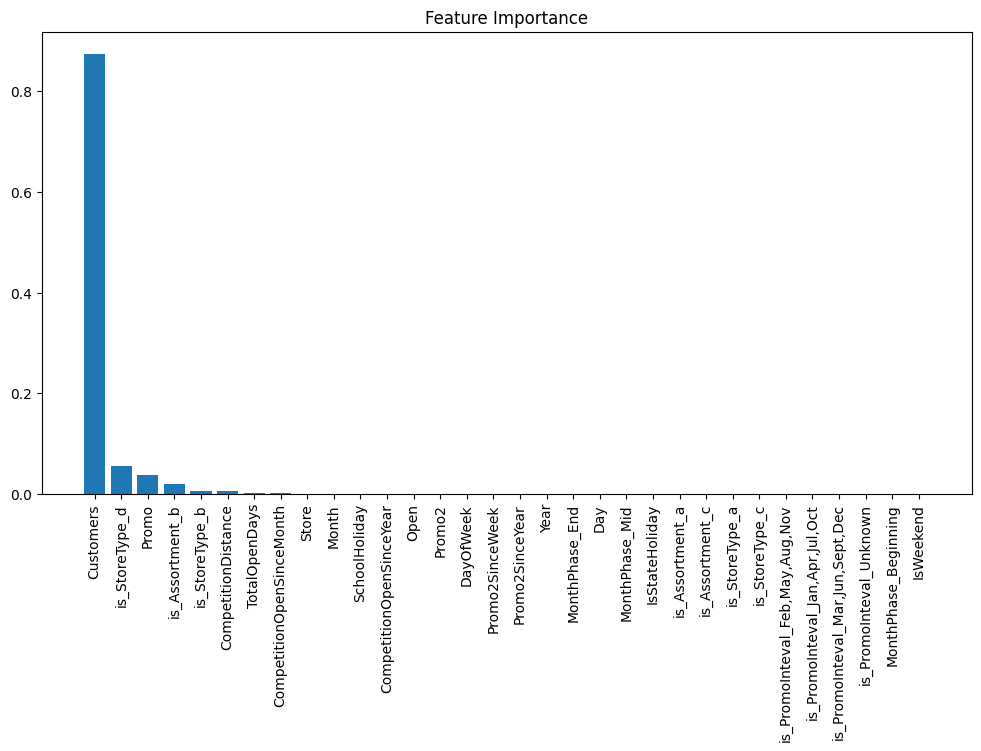

INFO:root:Feature importance plotted.


In [18]:
plot_feature_importance(rf_model, X.columns)

### Step 7: LSTM Model

In [19]:
X_train_scaled, X_test_scaled, scaler = scale_lstm_data(X_train, X_test)
X_train_lstm, X_test_lstm = reshape_lstm_data(X_train_scaled, X_test_scaled)
lstm_model = build_lstm_model(input_shape=(X_train_lstm.shape[1], 1))
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)
lstm_rmse, lstm_predictions = evaluate_lstm_model(lstm_model, X_test_lstm, y_test)

Epoch 1/10
21988/21988 ━━━━━━━━━━━━━━━━━━━━ 479s 22ms/step - loss: 54900912.0000
Epoch 2/10
21988/21988 ━━━━━━━━━━━━━━━━━━━━ 379s 17ms/step - loss: 41446820.0000
Epoch 3/10
21988/21988 ━━━━━━━━━━━━━━━━━━━━ 521s 24ms/step - loss: 30256214.0000
Epoch 4/10
21988/21988 ━━━━━━━━━━━━━━━━━━━━ 525s 24ms/step - loss: 21622860.0000
Epoch 5/10
21988/21988 ━━━━━━━━━━━━━━━━━━━━ 504s 23ms/step - loss: 15407649.0000
Epoch 6/10
21988/21988 ━━━━━━━━━━━━━━━━━━━━ 633s 29ms/step - loss: 11685445.0000
Epoch 7/10
21988/21988 ━━━━━━━━━━━━━━━━━━━━ 511s 23ms/step - loss: 10129211.0000
Epoch 8/10
21988/21988 ━━━━━━━━━━━━━━━━━━━━ 495s 22ms/step - loss: 9991127.0000
Epoch 9/10
21988/21988 ━━━━━━━━━━━━━━━━━━━━ 486s 22ms/step - loss: 9940304.0000
Epoch 10/10
21988/21988 ━━━━━━━━━━━━━━━━━━━━ 492s 22ms/step - loss: 9931349.0000
4398/4398 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step


In [20]:
print(lstm_rmse)
print(lstm_predictions)

3042.2810924676564
[[6966.494]
 [6966.494]
 [6966.494]
 ...
 [6966.494]
 [6966.494]
 [6966.494]]


In [24]:
serialize_model(lstm_model, 'lstm_model.pkl')

INFO:root:Serializing lstm_model.pkl and saving as lstm_model.pkl-2024-09-25-23-16-08.pkl.
INFO:root:Model lstm_model.pkl saved successfully.


'lstm_model.pkl-2024-09-25-23-16-08.pkl'

### Step 8: Visualization

INFO:root:Visualizing predicted vs actual sales.


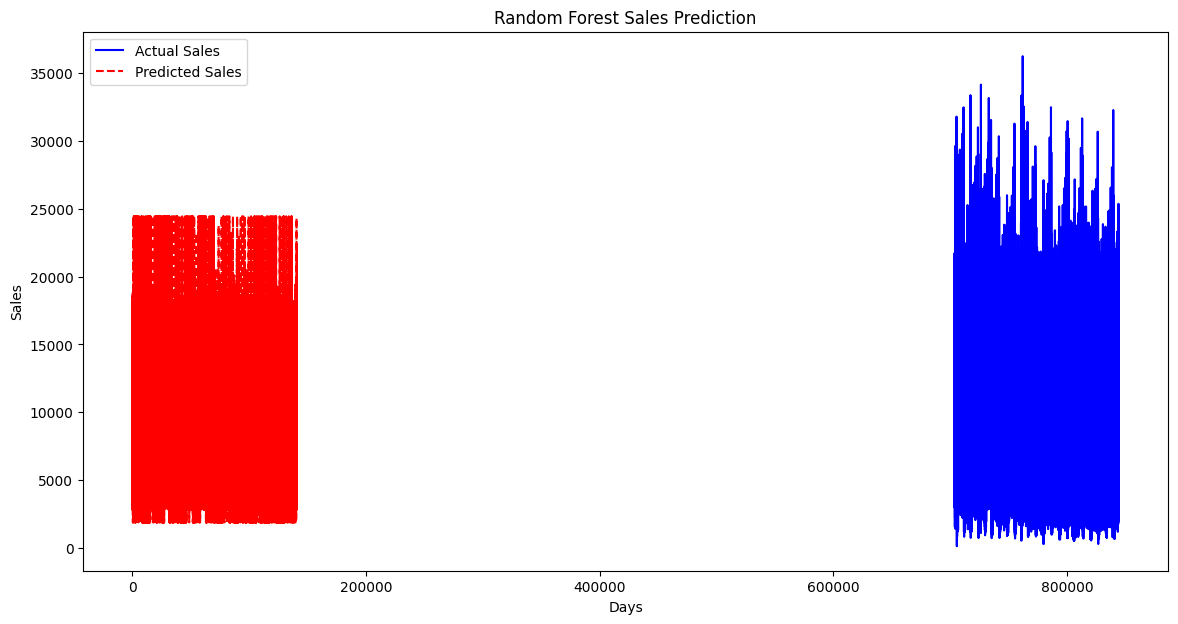

INFO:root:Sales predictions visualization completed.
INFO:root:Visualizing predicted vs actual sales.


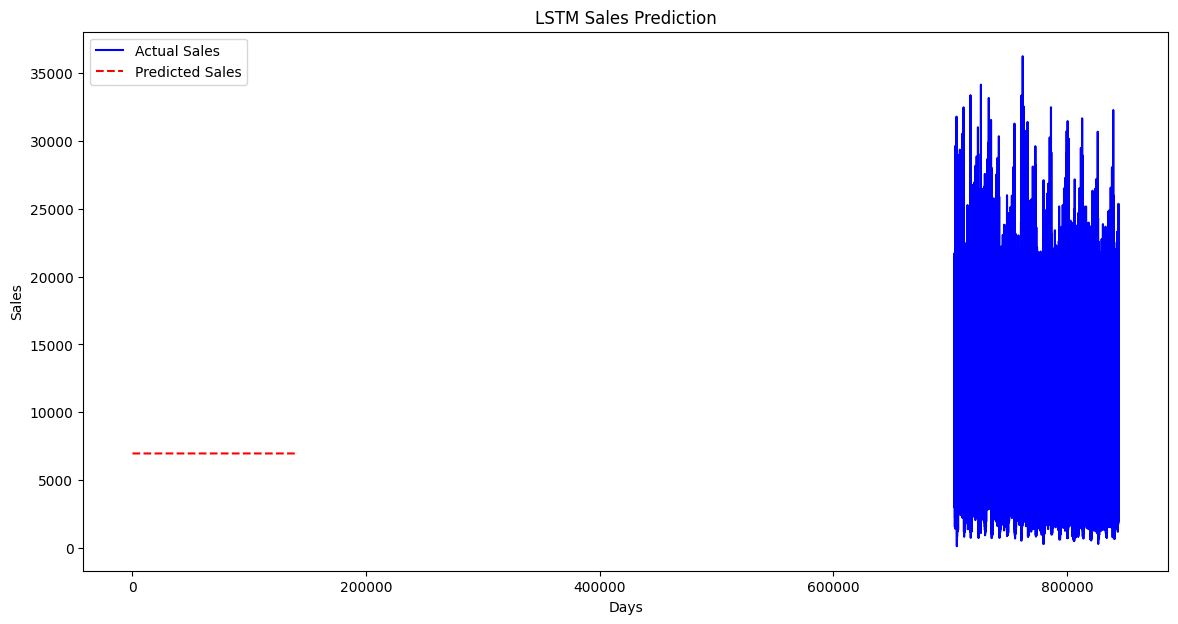

INFO:root:Sales predictions visualization completed.


In [21]:
# Visualize predictions
visualize_predictions(rf_predictions, y_test, title='Random Forest Sales Prediction')
visualize_predictions(lstm_predictions, y_test, title='LSTM Sales Prediction')

In [22]:
# Estimate confidence intervals
ci_lower, ci_upper = estimate_confidence_interval(rf_predictions, y_test)

INFO:root:Estimating confidence intervals.
INFO:root:95% confidence interval: [-215.92828677053683, -202.55042543565042]


In [23]:
print(ci_lower)
print(ci_upper)

-215.92828677053683
-202.55042543565042
